In [1]:
from __future__ import annotations

import pickle

with open("/mnt/shared/jmp-distributions-all-10-28/stats.pkl", "rb") as f:
    stats = pickle.load(f)

In [2]:
from typing import Any


def merge_stats(dataset_stats: list[dict[str, list[Any]]]):
    out: dict[str, list[Any]] = {}
    for stats in dataset_stats:
        for k, v in stats.items():
            if v is None:
                v = []
            if k not in out:
                out[k] = []
            out[k].extend(v)
    return out


stats["pretrain"] = merge_stats(
    [stats.pop(k) for k in ["oc20", "oc22", "ani1x", "trans1x"]]
)

KeyboardInterrupt: 

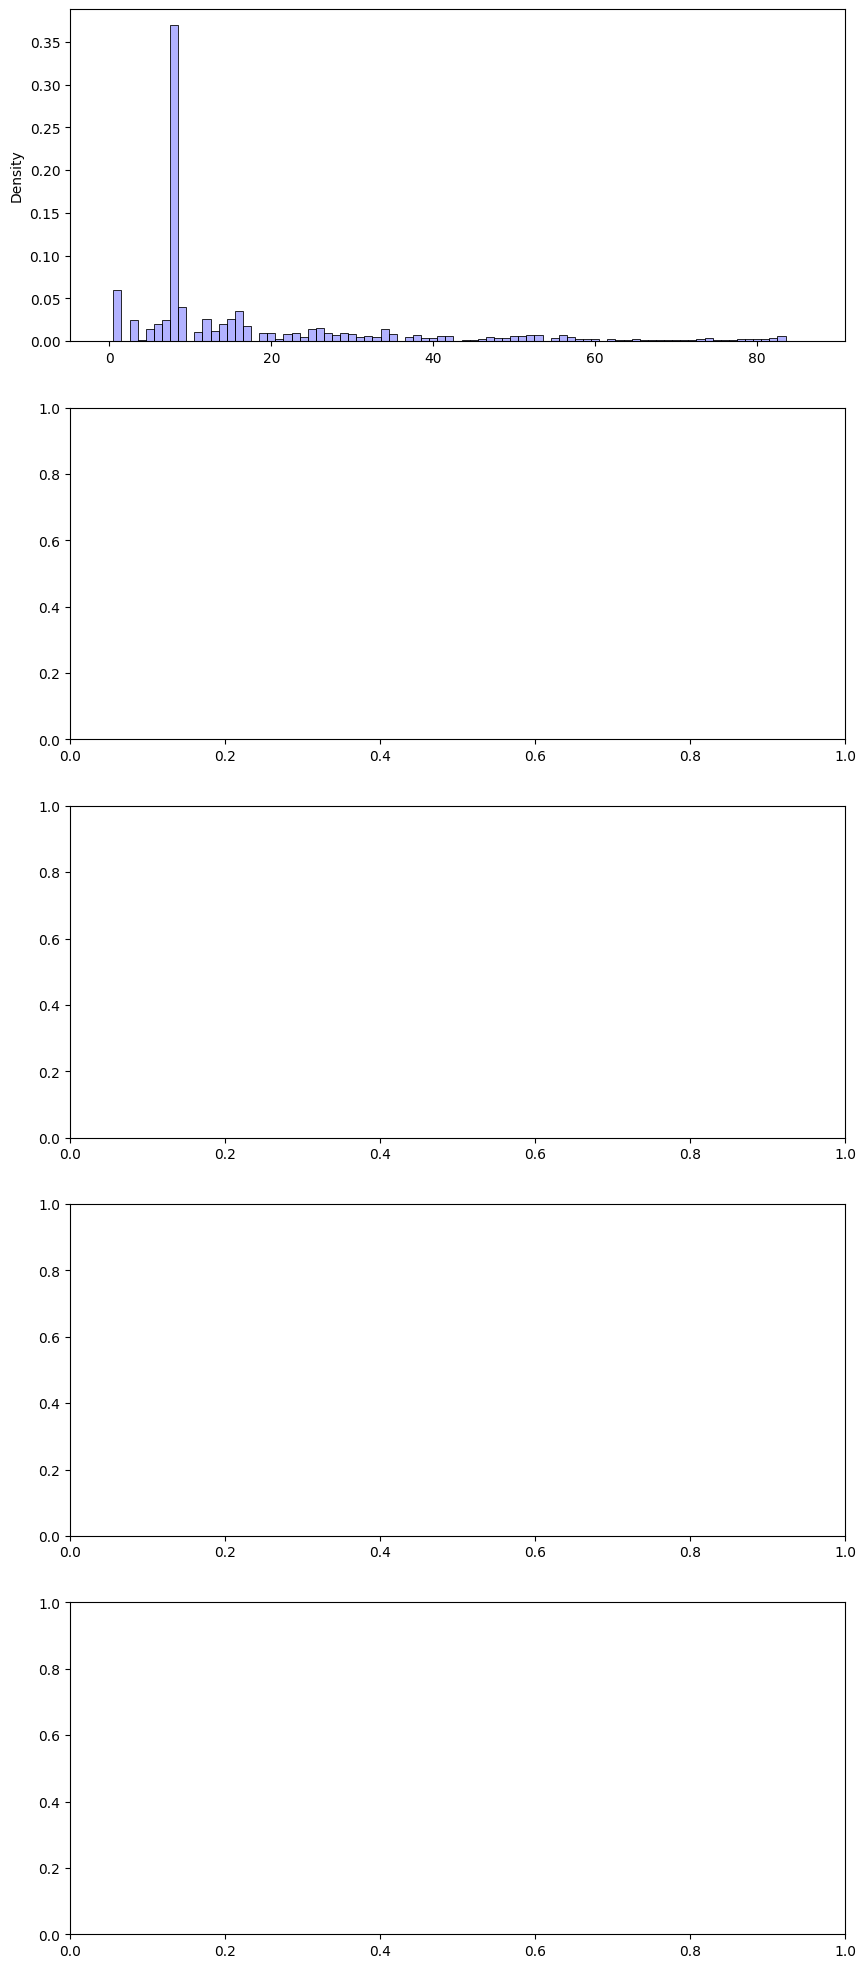

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from ase.data import chemical_symbols


def plot_all_stats_distributions(
    stats,
    *,
    colors,
    name_mapping={},
    nbins={},
    ranges={},  # New argument for specifying plot ranges
):
    # Get all unique keys from the stats dictionary
    all_keys = set()
    for dataset_stats in stats.values():
        all_keys.update(dataset_stats.keys())

    # Create a subplot for each key
    n_keys = len(all_keys)
    fig, axes = plt.subplots(n_keys, 1, figsize=(10, 5 * n_keys))
    if n_keys == 1:
        axes = [axes]

    for ax, key in zip(axes, sorted(all_keys)):
        if key == "atomic_numbers":
            # Special handling for atomic numbers
            # Get all unique atomic numbers across both datasets
            all_atomic_numbers = set()
            for s in stats.values():
                atomic_numbers_flat = np.concatenate(s["atomic_numbers"])
                all_atomic_numbers.update(atomic_numbers_flat)

            # Convert to sorted list and get corresponding symbols
            all_atomic_numbers = sorted(list(all_atomic_numbers))
            all_atomic_symbols = [chemical_symbols[num] for num in all_atomic_numbers]
            x_positions = np.arange(len(all_atomic_symbols))

            # Plot for each dataset
            for dataset, s in stats.items():
                atomic_numbers_flat = np.concatenate(s["atomic_numbers"])
                unique_atomic_numbers, counts = np.unique(
                    atomic_numbers_flat, return_counts=True
                )
                densities = counts / len(atomic_numbers_flat)

                # Create a mapping of atomic numbers to densities
                density_map = dict(zip(unique_atomic_numbers, densities))

                # Create density array matching the full atomic numbers list
                plot_densities = np.array(
                    [density_map.get(num, 0) for num in all_atomic_numbers]
                )

                # Plot bars
                sns.histplot(
                    data=atomic_numbers_flat,
                    bins=np.arange(-0.5, len(all_atomic_numbers) + 0.5),
                    stat="density",
                    color=colors[dataset],
                    alpha=0.3,
                    label=dataset.upper(),
                    ax=ax,
                )

                # Add KDE
                # Create more points for smoother KDE
                x_kde = np.linspace(-1, len(all_atomic_numbers), 200)
                kde = sns.kdeplot(
                    data=atomic_numbers_flat,
                    color=colors[dataset],
                    ax=ax,
                    linewidth=2,
                    bw_adjust=0.5,
                )

            # Show only first (H) and last atomic symbols
            ax.set_xticks([0, len(all_atomic_symbols) - 1])
            ax.set_xticklabels([all_atomic_symbols[0], all_atomic_symbols[-1]])

        else:
            # First determine global min and max for this key
            all_values = []
            for dataset, s in stats.items():
                if s[key] is None:
                    continue
                values = (
                    np.concatenate(s[key])
                    if isinstance(s[key][0], (list, np.ndarray))
                    else s[key]
                )
                all_values.extend(values)

            # Use specified range if provided, otherwise use data range
            if key in ranges:
                plot_min, plot_max = ranges[key]
            else:
                plot_min = min(all_values)
                plot_max = max(all_values)

            # Create consistent bins within the specified/computed range
            bins = np.linspace(plot_min, plot_max, nbins.get(key, 30))

            # Plot histograms and KDE for each dataset
            for dataset, s in stats.items():
                if s[key] is None:
                    continue
                values = (
                    np.concatenate(s[key])
                    if isinstance(s[key][0], (list, np.ndarray))
                    else s[key]
                )

                # Convert values to numpy array if it's not already
                values = np.asarray(values)

                # Filter values to be within the specified range
                mask = (values >= plot_min) & (values <= plot_max)
                filtered_values = values[mask]

                # Plot histogram
                sns.histplot(
                    data=filtered_values,
                    bins=bins,
                    alpha=0.3,
                    color=colors[dataset],
                    label=dataset.upper(),
                    stat="density",
                    ax=ax,
                )

                # Add KDE on top
                sns.kdeplot(
                    data=filtered_values,
                    color=colors[dataset],
                    ax=ax,
                    linewidth=2,
                    bw_adjust=0.5,
                )

            # Set the plot limits
            ax.set_xlim(plot_min, plot_max)

        # Set axis labels and title
        ax.set_title(f"Distribution of {name_mapping.get(key,key)}")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Example usage:
plot_all_stats_distributions(
    stats,
    colors={
        "mptrj": "blue",
        "wbm": "orange",
        "pretrain": "green",
    },
    name_mapping={
        "natoms": "Number of Atoms",
        "atomic_numbers": "Atom Types",
        "energies": "Energy per Atom",
    },
    ranges={
        "forces": (0.0, 5.0),
    },  # Restrict forces plot to range [0, 5]
)


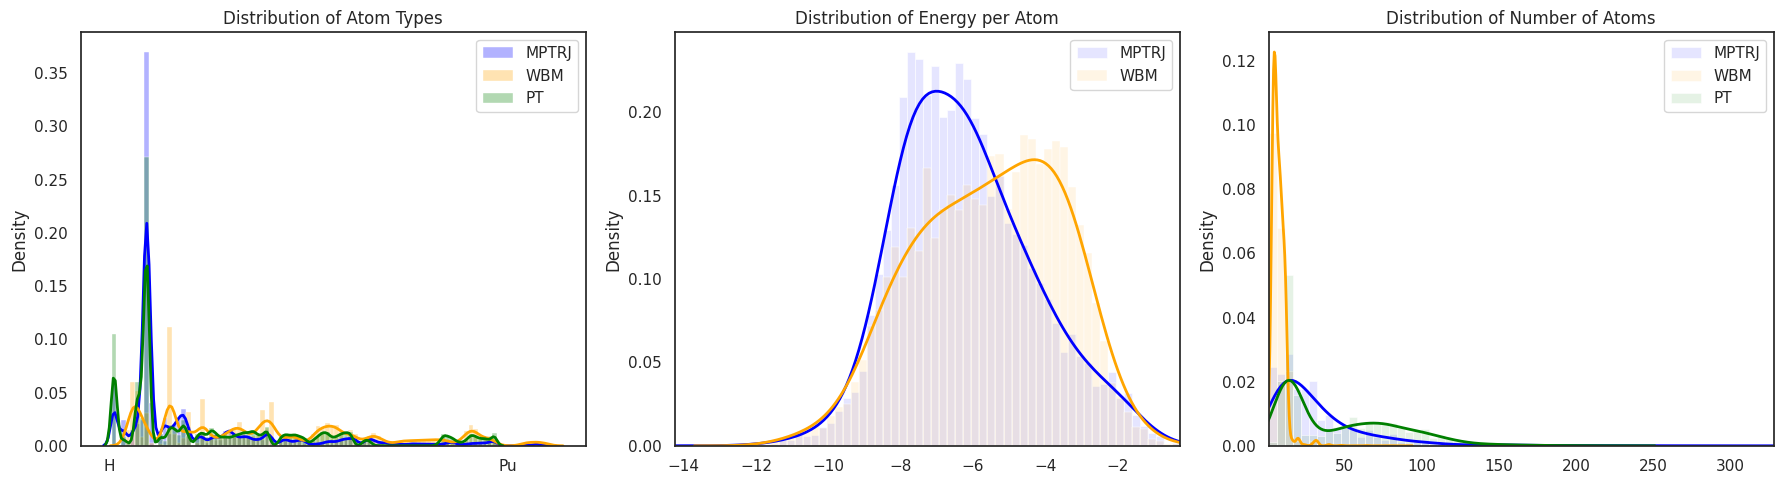

In [ ]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from ase.data import chemical_symbols

sns.set_theme(style="white")


def plot_all_stats_distributions(
    stats,
    *,
    colors,
    name_mapping={},
    nbins={},
    ranges={},  # Absolute value ranges
    qranges={},  # New argument for quartile-based ranges
    ignore_keys=set(),  # New argument for ignoring specific keys
):
    # Get all unique keys from the stats dictionary
    all_keys = set()
    for dataset_stats in stats.values():
        for key in dataset_stats.keys():
            if key in ignore_keys:
                continue
            all_keys.add(key)

    # Create a subplot for each key
    n_keys = len(all_keys)
    fig, axes = plt.subplots(1, n_keys, figsize=(6 * n_keys, 5))
    if n_keys == 1:
        axes = [axes]

    axes = np.asarray(axes).flatten()

    for ax, key in zip(axes, sorted(all_keys)):
        if key == "atomic_numbers":
            # Special handling for atomic numbers
            # Get all unique atomic numbers across both datasets
            all_atomic_numbers = set()
            for s in stats.values():
                atomic_numbers_flat = np.concatenate(s["atomic_numbers"])
                all_atomic_numbers.update(atomic_numbers_flat)

            # Convert to sorted list and get corresponding symbols
            all_atomic_numbers = sorted(list(all_atomic_numbers))
            all_atomic_symbols = [chemical_symbols[num] for num in all_atomic_numbers]
            x_positions = np.arange(len(all_atomic_symbols))

            # Plot for each dataset
            for dataset, s in stats.items():
                atomic_numbers_flat = np.concatenate(s["atomic_numbers"])
                unique_atomic_numbers, counts = np.unique(
                    atomic_numbers_flat, return_counts=True
                )
                densities = counts / len(atomic_numbers_flat)

                # Create a mapping of atomic numbers to densities
                density_map = dict(zip(unique_atomic_numbers, densities))

                # Create density array matching the full atomic numbers list
                plot_densities = np.array(
                    [density_map.get(num, 0) for num in all_atomic_numbers]
                )

                # Plot bars
                sns.histplot(
                    data=atomic_numbers_flat,
                    bins=np.arange(-0.5, len(all_atomic_numbers) + 0.5),
                    stat="density",
                    color=colors[dataset],
                    alpha=0.3,
                    label=dataset.upper(),
                    ax=ax,
                )

                # Add KDE
                # Create more points for smoother KDE
                x_kde = np.linspace(-1, len(all_atomic_numbers), 200)
                kde = sns.kdeplot(
                    data=atomic_numbers_flat,
                    color=colors[dataset],
                    ax=ax,
                    linewidth=2,
                    bw_adjust=0.5,
                )

            # Show only first (H) and last atomic symbols
            ax.set_xticks([0, len(all_atomic_symbols) - 1])
            ax.set_xticklabels([all_atomic_symbols[0], all_atomic_symbols[-1]])

        else:
            # First determine global min and max for this key
            all_values = []
            for dataset, s in stats.items():
                if s[key] is None:
                    continue
                values = (
                    np.concatenate(s[key])
                    if isinstance(s[key][0], (list, np.ndarray))
                    else s[key]
                )
                all_values.extend(values)

            all_values = np.array(all_values)

            # Determine plot range based on provided specifications
            if key in ranges:
                plot_min, plot_max = ranges[key]
            elif key in qranges:
                q_min, q_max = qranges[key]
                plot_min = np.quantile(all_values, q_min)
                plot_max = np.quantile(all_values, q_max)
            else:
                plot_min = min(all_values)
                plot_max = max(all_values)

            # Create consistent bins within the specified/computed range
            bins = np.linspace(plot_min, plot_max, nbins.get(key, 64))

            # Plot histograms and KDE for each dataset
            for dataset, s in stats.items():
                if s[key] is None:
                    continue
                values = (
                    np.concatenate(s[key])
                    if isinstance(s[key][0], (list, np.ndarray))
                    else s[key]
                )

                # Convert values to numpy array if it's not already
                values = np.asarray(values)

                # Filter values to be within the specified range
                mask = (values >= plot_min) & (values <= plot_max)
                filtered_values = values[mask]

                # Plot histogram
                sns.histplot(
                    data=filtered_values,
                    bins=bins,
                    alpha=0.1,
                    color=colors[dataset],
                    label=dataset.upper(),
                    stat="density",
                    ax=ax,
                )

                # Add KDE on top
                sns.kdeplot(
                    data=filtered_values,
                    color=colors[dataset],
                    ax=ax,
                    linewidth=2,
                    bw_adjust=2.0,
                    # alpha=0,
                )

            # Set the plot limits
            ax.set_xlim(plot_min, plot_max)

        # Set axis labels and title
        ax.set_title(f"Distribution of {name_mapping.get(key,key)}")
        ax.legend()
        # ax.grid(True, alpha=0.3)

    fig.tight_layout()


stats_copy = copy.deepcopy(stats)
stats_copy["pretrain"]["energies"] = None
stats_copy["pt"] = stats_copy.pop("pretrain")


plot_all_stats_distributions(
    stats_copy,
    colors={
        "mptrj": "blue",
        "wbm": "orange",
        "pt": "green",
    },
    name_mapping={
        "natoms": "Number of Atoms",
        "atomic_numbers": "Atom Types",
        "energies": "Energy per Atom",
    },
    ranges={
        "forces": (0.0, 5.0),
    },  # Restrict forces plot to range [0, 5]
    qranges={
        # "energies": (0.1, 0.9),  # Show data between 10th and 90th percentiles
    },
    ignore_keys={
        "forces",
        "stresses",
    },  # Ignore forces plot
    order=[""]
)
plt.savefig("dists.pdf", bbox_inches="tight")
plt.show()